<a href="https://colab.research.google.com/github/VKapicyn/m06-006sk-course-work-var2/blob/master/Ant_Colony_on_1024Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперименты с графом

In [95]:
import networkx as nx
from networkx.readwrite import json_graph
import json
import time
import matplotlib.pyplot as plt

In [3]:
#создание графа
G = nx.gnm_random_graph(1024, 4000, directed=False)

#проверка графа на наличие несвязанных узлов
sum = 0
zeros = 0
for i in G:
  sum += G.degree[i]
  if G.degree[i] == 0:
    zeros += 1
print(sum/G.number_of_nodes())
print(zeros)

In [97]:
# Считываем граф из файла
iteration_number = "17"
file_name = "darvin_graph_"+iteration_number+".json"
G = nx.DiGraph()
with open('/content/sample_data/'+file_name, 'r') as readfile:
  js_graph = json.load(readfile)
  G = json_graph.node_link_graph(js_graph, directed=True)

# итерация узлов
if len(G.nodes)<50 :
  for i in range(0, len(G.nodes)):
    print(i)
    print(g.edges(i))


# Рисуем граф если граф тестовый (граф из 1024 точек адекватно не отображается)
if len(G.nodes)<50 :
  nx.draw(G, with_labels=True)
  plt.show()

print("Граф готов")

Граф готов


# Эксперименты с муравьями

Следующий блок кода является модифицированным кодом из репозитория https://github.com/Akavall/AntColonyOptimization

---


Этот блок кода реализует прохождение муравьиной колонии по графу с целью поиска кратчайшего пути

Алгоритм состоит из N итераций. Кол-во итераций задаётся в параметр n_iterations.

---
Cчитаем что точка А - это G[0], точка B - это G[nodes-1].

Есть K муравьёв. Кажда частица совершает случайные блуждания по маршруту n_iterations раз, то есть K раз происходит проход по графу для каждой итерации

Содержание каждой итерации:

1. Выпускается K муравьёв (задаётся параметром n_ants) в функции **gen_all_paths()**
2. Собираются путь каждого муравья (ф-я **gen_path()**) при том, что муравей выбирает, куда ему идти в функции **pick_move()**
    1. Если муравей достигает точки B, то его путь заканчивается
    2. Если муравей превышает число шагов, заданный параметром **max_moves**, то он "умирает" и его путь не защитывается
3. Для каждого собранного пути считается его дистанция (ф-я **gen_path_dist()**)
4. В зависимости от длинны дистанции выбираются **n_best** самых успешных дистанций. На них распыляется феромон (ф-я **spread_pheromone()**)
5. После этого происходит испарение феромона со всех рёбер графа, заданное параметром **decay**

Веса муравьёв обновляются при каждом переходе и считаются, как: 
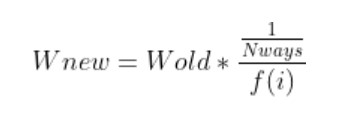


In [98]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

  def __init__(self, graph, n_ants, n_best, n_iterations, decay, max_moves):

    self.graph = graph
    self.distances  = nx.to_numpy_array(graph)
    self.pheromone = np.copy(self.distances)
    self.n_ants = n_ants
    self.n_best = n_best
    self.n_iterations = n_iterations
    self.decay = decay
    self.alpha = 1
    self.beta = 1
    self.max_moves = max_moves
    self.weights = 0
    self.min_path = max_moves

  #ГОТОВО
  def run(self):
    shortest_path = None
    all_time_shortest_path = ("placeholder", np.inf)
    for i in range(self.n_iterations):
        self.weights = 0
        all_paths = self.gen_all_paths() #получаем все пути муравьёв за эту итерацию
        self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path) #распыляем феромоны на путях в зависимости от их итоговой длинны
        shortest_path = min(all_paths, key=lambda x: x[1]) #находим кратчайший путь из всех муравьиных

        #если нашли более короткий путь, чем был раньше, то заменяем
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path            
        self.pheromone = self.pheromone * self.decay #испаряем феромон
    self.min_path = shortest_path[1]
    print("shortest:", self.min_path, "weights:", self.weights)
    return all_time_shortest_path

  #ГОТОВО
  def spread_pheronome(self, all_paths, n_best, shortest_path):
    sorted_paths = sorted(all_paths, key=lambda x: x[1]) #сортируем пути по дистанции от минимальной к максимальной
    for path, dist in sorted_paths[:n_best]: #распыляем феромон на пути с наименьшей дистанцией
      if dist < self.max_moves:
        for move in path:
            self.pheromone[move[0]][move[1]] += 25.0 / dist #self.distances[move] #к феромону прибавляется значение обратно пропорциональное пройденной дистанции
  
  #ГОТОВО: суммируем длинну пути
  def gen_path_dist(self, path):
    total_dist = 0
    for step in path:
        total_dist += self.distances[step]
    return total_dist

  #ГОТОВО: собираем пути всех муравьёв
  def gen_all_paths(self):
    all_paths = []
    # выпускаем N муравьёв
    for i in range(self.n_ants):
        path = self.gen_path(start = 0) # каждый муравей проходит свой путь, начиная с 0-го узла
        all_paths.append((path, self.gen_path_dist(path))) # этот путь присоединяется к копилке всех путей этой итерации муравейника
    return all_paths

  # то, как муравей проходит свой путь
  def gen_path(self, start):
    path = []
    #visited = set()
    #visited.add(start)
    weight = 1;
    prev = start
    i = 0
    while (prev != 1023): # цикл до попадания муравья в нужный узел
      move, weight = self.pick_move(self, self.pheromone, prev, path, weight) # муравей выбирает следующий шаг
      path.append((prev,move))
      # муравей, зашедший в тупик, возвращается на базу до следующего выхода
      #if G.degree[move] == 1:
      #  return 0;
      # муравей, гуляющий слишком долго, возвращается на базу до следующего выхода
      i += 1
      if i >= self.max_moves:
        break
      prev = move
    if (prev == 1023): #если всё-таки дошёл, то добавляем вес
      self.weights = self.weights + weight
    return path
  

  def pick_move(self, pheromone, dist, prev, path, old_weight):
      #pheromone = np.copy(pheromone)
      neighbours = np.array(list(self.graph.adj[prev])) # список соседей (вариантов)
      buff = []
      for i in neighbours:
        #if any(p[0] == i for p in path):
        if len(path) != 0 and i == path[-1][0]:
           buff.append(0.000001) # есои муравей там уже был, то вернётся с меньшей вероятностью
        else:
           buff.append(self.pheromone[prev][i])
        
      phers = np.array(buff)# список феромонов на соседях

      #for i in phers:  
      #  i = i ** self.alpha  # предпочтительность соседа при выборе пути. Забил на длинну, так как везде 1
      row = phers ** self.alpha #* (( 1.0 / dist[prev]) ** self.beta) 
      
      #row = np.ones(np.shape(neighbours))
      norm_row = row / row.sum() # нормированная предпочтительность
      
      np.random.seed()
      move = np_choice(a = neighbours, size = 1, p=norm_row)[0] # волшебство выбора
      new_weight = old_weight / (len(neighbours) * norm_row[np.where(neighbours == move)])

      return move, new_weight

In [99]:
weight_arr = []
time_arr = []
all_time = 0
for i in range(0,50):
  start = time.time()
  ants = AntColony(G, n_ants = 35, n_best = 5, n_iterations = 20, decay = 0.95, max_moves = 100)
  print ("working... ", i)
  shortest_path = ants.run()
  work_time = time.time() - start
  print ("time:", work_time)
  weight_arr.append(ants.weights[0])
  time_arr.append(work_time)
  all_time = all_time + work_time

working...  0
shortest: 9.0 weights: [0.00247683]
time: 5.436213254928589
working...  1
shortest: 9.0 weights: [0.00460201]
time: 5.070067882537842
working...  2
shortest: 9.0 weights: [0.00412821]
time: 7.1567933559417725
working...  3
shortest: 11.0 weights: [0.00207637]
time: 5.0462329387664795
working...  4
shortest: 9.0 weights: [0.00532385]
time: 5.11150050163269
working...  5
shortest: 11.0 weights: [0.00206461]
time: 6.123997211456299
working...  6
shortest: 11.0 weights: [0.00209712]
time: 7.3387532234191895
working...  7
shortest: 9.0 weights: [0.00255296]
time: 6.283928155899048
working...  8
shortest: 9.0 weights: [0.01569541]
time: 6.084435224533081
working...  9
shortest: 11.0 weights: [0.00219506]
time: 6.4601287841796875
working...  10
shortest: 9.0 weights: [0.0059897]
time: 4.63750958442688
working...  11
shortest: 9.0 weights: [0.00406937]
time: 4.874067306518555
working...  12
shortest: 9.0 weights: [0.00744481]
time: 5.279510021209717
working...  13
shortest: 11.0 

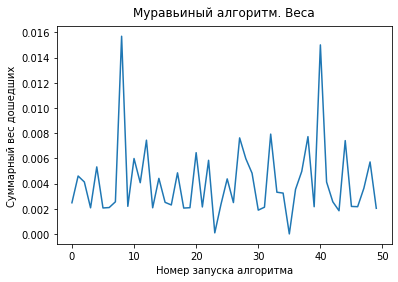

In [111]:
plt.plot(weight_arr)
plt.xlabel("Номер запуска алгоритма")
plt.ylabel("Суммарный вес дошедших")
plt.title(label="Муравьиный алгоритм. Веса", fontsize=12, fontweight=18, pad=10)
plt.show()

2.052449694851651e-06 fff 0.0005122802322189786


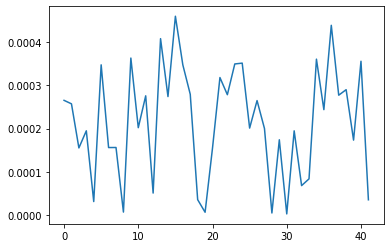

In [75]:
arr = []
tmp = np.var(weight_arr)
mean = np.mean(weight_arr)

for i in range(0, len(weight_arr)):
  if weight_arr[i] < mean:
    arr.append(weight_arr[i])
plt.plot(arr)
plt.show
print(tmp, "fff", mean)

0.004135616631417681 + 9.053052225690694e-05 - 0.01569541363967593 = -0.011550743956032557
0.004135616631417681 + 9.053052225690694e-05 - 0.015009265358990321 = -0.01086459567534695


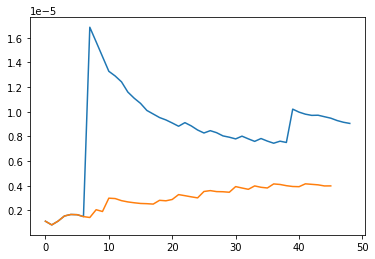

In [104]:
d = []
da = []
arr = []
tmp = np.var(weight_arr)
mean = np.mean(weight_arr)
for i in range(0, len(weight_arr)-1):
  if weight_arr[i] < 2.0*mean + 10.0*tmp:
    arr.append(weight_arr[i])
  else:
    print(mean, "+", 10.0*tmp, "-", weight_arr[i], "=", mean + 1.0*tmp - weight_arr[i])

for i in range(1, len(weight_arr)):
    d.append(np.var(weight_arr[:i+1]))


for i in range(1, len(arr)):
    da.append(np.var(arr[:i+1]))

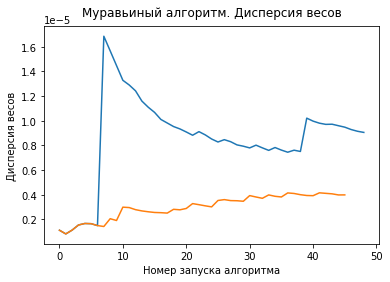

In [112]:
plt.plot(d)
plt.plot(da)
plt.xlabel("Номер запуска алгоритма")
plt.ylabel("Дисперсия весов")
plt.title(label="Муравьиный алгоритм. Дисперсия весов", fontsize=12, fontweight=18, pad=10)
plt.show()

In [114]:
print("Средний вес:", np.mean(weight_arr))
print("Среднее время:", np.mean(time_arr))
print("FOM1:", 1/(np.mean(d)*np.mean(time_arr)))
print("FOM2:", 1/(np.mean(da)*np.mean(time_arr)))

Средний вес: 0.004135616631417681
Среднее время: 6.079779272079468
FOM1: 19289.651696559402
FOM2: 54429.643814767645


In [105]:
print(nx.dijkstra_path(G,0,1023))

[0, 886, 370, 608, 726, 822, 574, 36, 596, 1023]
